In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn')

In [3]:
np.random.seed(123)

alpha, sigma, beta = 1, 1, [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size)

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

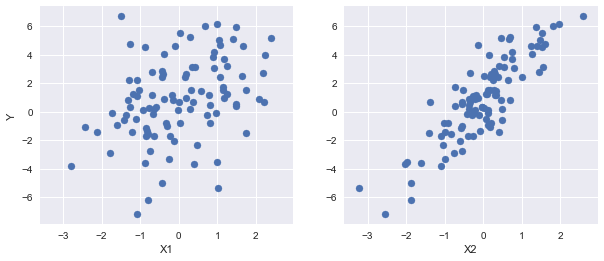

In [4]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2');

In [5]:
import pymc3 as pm
print(f'Running on PyMC3 v{pm.__version__}')

Running on PyMC3 v3.8


In [6]:
basic_model = pm.Model()

with basic_model:
    
    # Set priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [7]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

logp = -155.59, ||grad|| = 51.974: 100%|██████████| 19/19 [00:00<00:00, 2186.39it/s]  


{'alpha': array(0.90661753),
 'beta': array([0.94850377, 2.52246124]),
 'sigma_log__': array(-0.03771521),
 'sigma': array(0.96298715)}

In [8]:
map_estimate = pm.find_MAP(model=basic_model, method='powell')
map_estimate

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/joshtracy/repos/school/bayesian-baseball-modeling/.venv/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149, ||grad|| = 2.3203: 100%|██████████| 270/270 [00:00<00:00, 2414.81it/s]      


{'alpha': array(0.90661033),
 'beta': array([0.94849417, 2.5224695 ]),
 'sigma_log__': array(-0.03771493),
 'sigma': array(0.96298742)}

In [9]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3557.19draws/s]


In [10]:
trace['alpha'][-5:]

array([0.79576438, 1.03587013, 0.88111969, 0.84191448, 0.96544067])

In [11]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:08<00:00, 2690.89draws/s]


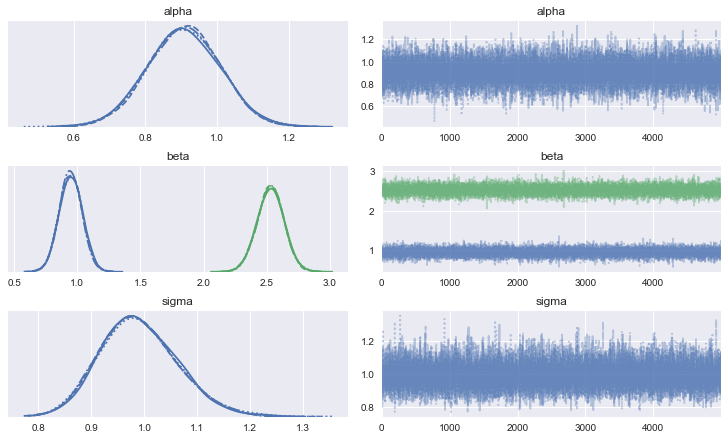

In [14]:
pm.traceplot(trace, figsize=(10, 6));

In [15]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.10,0.72,1.09,0.0,0.0,20361.0,20282.0,20375.0,14389.0,1.0
beta[0],0.95,0.09,0.78,1.11,0.0,0.0,19338.0,19184.0,19345.0,15262.0,1.0
beta[1],2.53,0.10,2.34,2.72,0.0,0.0,16685.0,16502.0,16668.0,12946.0,1.0
sigma,0.99,0.07,0.85,1.12,0.0,0.0,18040.0,17765.0,18152.0,14390.0,1.0


## Case Study 1: Stochastic volatility

In [16]:
import pandas as pd
from datetime import datetime

returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)
returns_2008 = returns.loc[
    (returns.index >= datetime(2018, 5, 1)) &
    (returns.index < datetime(2019, 12, 31))
].copy()

len(returns_2008)

390

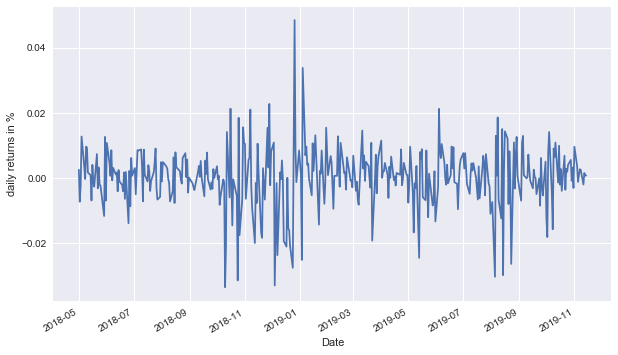

In [17]:
returns_2008.change.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [38]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10.0, testval=5.0)
    sigma = pm.Exponential('sigma', 1/0.02, testval=0.1)
    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns_2008))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)
    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns_2008['change'])

In [39]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:06<00:00, 149.29draws/s]
The acceptance probability does not match the target. It is 0.6671555003686376, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


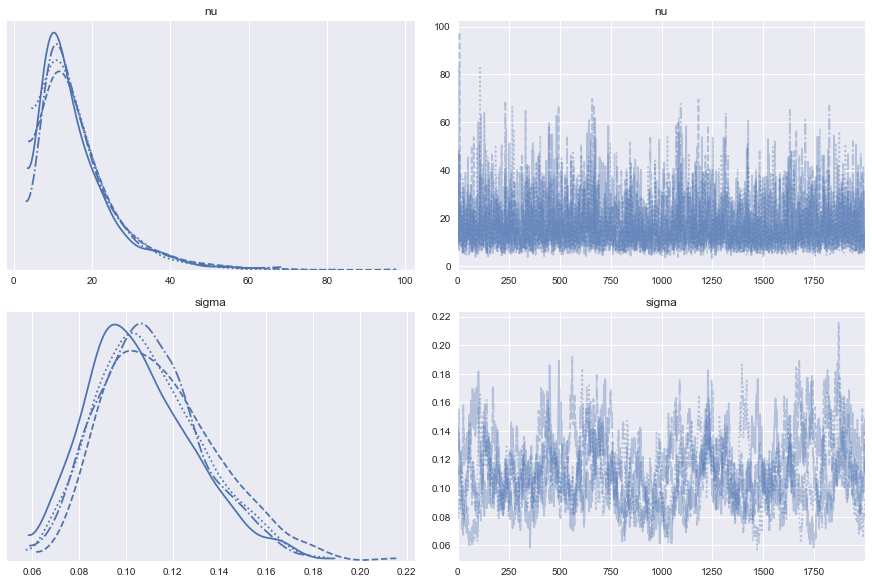

In [40]:
pm.traceplot(
    trace,
    var_names=['nu', 'sigma'],
    figsize=(12, 8)
);

/Users/joshtracy/repos/school/bayesian-baseball-modeling/.venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


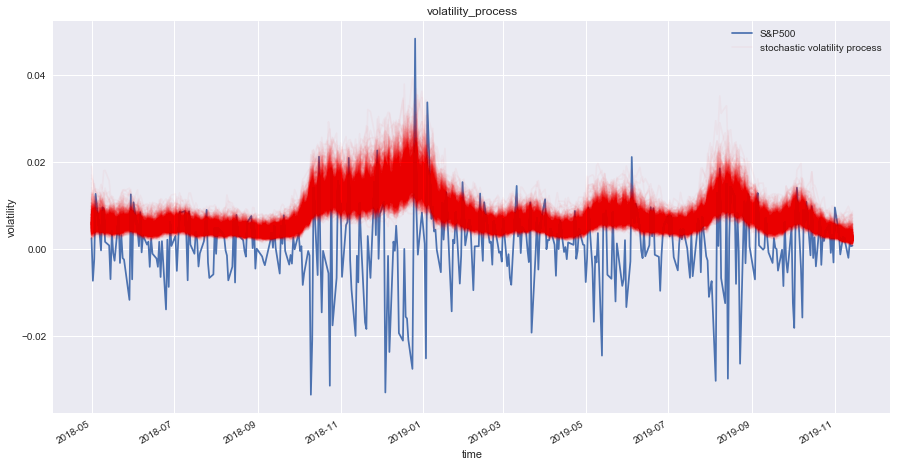

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))
returns_2008.change.plot(ax=ax)
ax.plot(returns_2008.index, 1/np.exp(trace['s', ::5].T), color='r', alpha=0.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

## Case study 2: Coal mining disasters

In [46]:
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

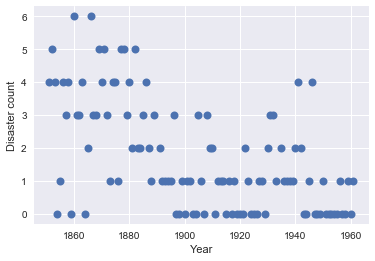

In [48]:
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8)
plt.ylabel('Disaster count')
plt.xlabel('Year');

In [49]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

/Users/joshtracy/repos/school/bayesian-baseball-modeling/.venv/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [50]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:10<00:00, 3872.15draws/s]
The number of effective samples is smaller than 10% for some parameters.


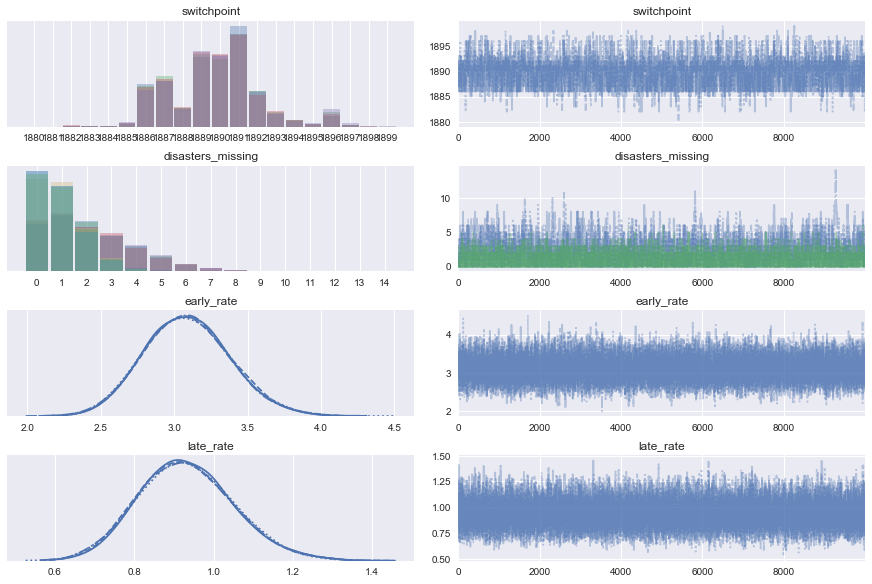

In [51]:
pm.traceplot(trace);

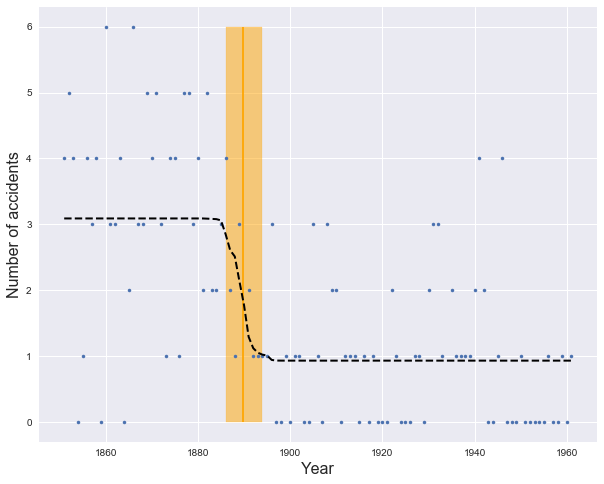

In [56]:

plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='orange')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='orange');
plt.plot(years, average_disasters,  'k--', lw=2);

In [59]:
with pm.Model() as nu_model:
    alpha = pm.Mv()
    beta = pm.Normal()
    gamma = pm.Normal()
    nu = pm.Dirichlet()
    sup = pm.Deterministic()